In [1]:
!pip install pytorchvideo
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 1.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for av from https://files.pythonhosted.org/packages/0a/32/56aaa677f0ec369eb68623a2ade90358c1a51b6e3cd6087111bd1e096b82/av-11.0.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for portalocker from https://files.pythonhosted.org/packages/17/9e/87671efcca80ba6203811540ed1f9c0462c1609d2281d7b7f53cef05da3d/portalocker-2.8.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 12.3 MB/s eta 0:00:0000:0100:01
  Created wheel for pytorchvideo: filename=pytorchvideo-0.1.5-py3-none-any.whl size=188685 sha256=0

In [2]:
import numpy as np
import pandas as pd
import cv2
import os
import random

random_seed = 13
np.random.seed(random_seed)
random.seed(random_seed)

# Load model

In [3]:
import wandb
wandb.login(key="1658d378d091cf8659e37004bc727f76b3de8356")
run = wandb.init(project="DL2023_infer2")
artifact = run.use_artifact('chinh/DL2023_bungno/model-ydxevbtm:v2', type='model')
artifact_dir = artifact.download()

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: duongchinh29062003 (chinh). Use `wandb login --relogin` to force relogin


wandb:   1 of 1 files downloaded.  


In [4]:
import torch
import torch.nn as nn
from pytorch_lightning import LightningModule

class MyModel(LightningModule):
    def __init__(self):
        super().__init__()
        vid_mod = torch.hub.load('facebookresearch/pytorchvideo', model='efficient_x3d_xs', pretrained=True)
        self.vid_model = vid_mod
        self.relu = nn.ReLU()
        self.linear = nn.Linear(400, 1)
        #parameters
        self.lr=1e-3
        self.batch_size = 2
        #loss function
        self.loss = nn.BCEWithLogitsLoss()
    
    def forward(self, x):
        x = self.vid_model(x)
        x = self.relu(x)
        x = self.linear(x)
        return x
        
    def training_step(self, batch, batch_idx):
        y_hat = self(batch['video'])
        loss = self.loss(y_hat, batch['label'])
        self.log("train_loss", loss, sync_dist=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        y_hat = self(batch['video'])
        loss = self.loss(y_hat, batch['label'])
        self.log("val_loss", loss, sync_dist=True)
        return loss
    
    def configure_optimizers(self):
        opt = torch.optim.AdamW(params=self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)
        return {'optimizer':opt, 'lr_scheduler':scheduler}

In [5]:
artifact_dir

'/kaggle/working/artifacts/model-ydxevbtm:v2'

In [6]:
video_model = torch.hub.load('facebookresearch/pytorchvideo', model='efficient_x3d_xs', pretrained=True)

Downloading: "https://github.com/facebookresearch/pytorchvideo/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/pytorchvideo/model_zoo/kinetics/efficient_x3d_xs_original_form.pyth" to /root/.cache/torch/hub/checkpoints/efficient_x3d_xs_original_form.pyth
100%|██████████| 14.8M/14.8M [00:00<00:00, 39.9MB/s]


In [7]:
model = MyModel.load_from_checkpoint(artifact_dir+'/model.ckpt')

Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


In [8]:
# from IPython.display import clear_output, Image, display, HTML, Video
# Video('/kaggle/input/security-videos/dl2023/abnormal/ab_001.mp4')

# Data Loader

In [9]:
import os
import cv2
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
paths = [
    '/kaggle/input/crimeucfdataset/Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-1/Abuse/*',
    '/kaggle/input/crimeucfdataset/Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-1/Arrest/*',
    '/kaggle/input/crimeucfdataset/Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-1/Arson/*',
    '/kaggle/input/crimeucfdataset/Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-1/Assault/*',
    '/kaggle/input/crimeucfdataset/Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-2/Burglary/*',
    '/kaggle/input/crimeucfdataset/Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-2/Explosion/*',
    '/kaggle/input/crimeucfdataset/Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-2/Fighting/*'
]

In [11]:
normal = glob('/kaggle/input/crimeucfdataset/Anomaly_Dataset/Anomaly_Videos/Normal-Videos-Part-1/*')
abnormal = []
for i in paths:
    abnormal.extend(glob(i))
    
label = [0]*len(normal)+[1]*len(abnormal)
df = pd.DataFrame(zip(normal+abnormal, label), columns=['file', 'label'])
print('Normal: ', len(normal))
print('Abnormal: ', len(abnormal))
df['label'] = df['label'].astype(int)
df.head(), df.tail()

Normal:  150
Abnormal:  400


(                                                file  label
 0  /kaggle/input/crimeucfdataset/Anomaly_Dataset/...      0
 1  /kaggle/input/crimeucfdataset/Anomaly_Dataset/...      0
 2  /kaggle/input/crimeucfdataset/Anomaly_Dataset/...      0
 3  /kaggle/input/crimeucfdataset/Anomaly_Dataset/...      0
 4  /kaggle/input/crimeucfdataset/Anomaly_Dataset/...      0,
                                                   file  label
 545  /kaggle/input/crimeucfdataset/Anomaly_Dataset/...      1
 546  /kaggle/input/crimeucfdataset/Anomaly_Dataset/...      1
 547  /kaggle/input/crimeucfdataset/Anomaly_Dataset/...      1
 548  /kaggle/input/crimeucfdataset/Anomaly_Dataset/...      1
 549  /kaggle/input/crimeucfdataset/Anomaly_Dataset/...      1)

In [12]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.15, shuffle=True, random_state=random_seed)
train_df, val_df

(                                                  file  label
 65   /kaggle/input/crimeucfdataset/Anomaly_Dataset/...      0
 113  /kaggle/input/crimeucfdataset/Anomaly_Dataset/...      0
 108  /kaggle/input/crimeucfdataset/Anomaly_Dataset/...      0
 168  /kaggle/input/crimeucfdataset/Anomaly_Dataset/...      1
 236  /kaggle/input/crimeucfdataset/Anomaly_Dataset/...      1
 ..                                                 ...    ...
 153  /kaggle/input/crimeucfdataset/Anomaly_Dataset/...      1
 528  /kaggle/input/crimeucfdataset/Anomaly_Dataset/...      1
 74   /kaggle/input/crimeucfdataset/Anomaly_Dataset/...      0
 176  /kaggle/input/crimeucfdataset/Anomaly_Dataset/...      1
 338  /kaggle/input/crimeucfdataset/Anomaly_Dataset/...      1
 
 [467 rows x 2 columns],
                                                   file  label
 0    /kaggle/input/crimeucfdataset/Anomaly_Dataset/...      0
 456  /kaggle/input/crimeucfdataset/Anomaly_Dataset/...      1
 405  /kaggle/input/crimeucf

In [13]:
train_df.to_csv('train.txt', sep=' ', index=False, header=False)
val_df.to_csv('val.txt', sep=' ', index=False, header=False)

In [14]:
from pytorchvideo.data import LabeledVideoDataset, make_clip_sampler, labeled_video_dataset
from pytorch_lightning import LightningDataModule
import torch

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    ShortSideScale,
    UniformTemporalSubsample,
    Permute
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize
)

from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo
)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


In [15]:
video_transform=Compose([
    ApplyTransformToKey(
        key='video',
        transform = Compose([
        UniformTemporalSubsample(64),
        Lambda(lambda x: x/255),
        Normalize((0.45, 0.45, 0.45), (0.225, 0.225, 0.225)),
        ShortSideScale(60),
        RandomHorizontalFlip(p=0.5)
        ])
    ),
    ApplyTransformToKey(
        key='label',
        transform = Lambda(lambda x: torch.tensor([float(x)]))
    )
])

In [16]:
from torch.utils.data import DataLoader
class MyDataModule(LightningDataModule):
    def __init__(self):
        super().__init__()
        self.BATCH_SIZE = 1
        self.NUM_WORKERS = 0
    
    def train_dataloader(self):
        train_dataset = labeled_video_dataset(
            '/kaggle/working/train.txt',
            clip_sampler=make_clip_sampler('random', 25.6),
            transform=video_transform,
            decode_audio=False
        )
        train_loader = DataLoader(train_dataset, batch_size=self.BATCH_SIZE, num_workers=self.NUM_WORKERS, shuffle=False)
        return train_loader
    
    def val_dataloader(self):
        val_dataset = labeled_video_dataset(
            '/kaggle/working/val.txt',
            clip_sampler=make_clip_sampler('random', 25.6),
            transform=video_transform,
            decode_audio=False
        )
        val_loader = DataLoader(val_dataset, batch_size=self.BATCH_SIZE, num_workers=self.NUM_WORKERS, shuffle=False)
        return val_loader
    
    def test_dataloader(self):
        test_dataset = labeled_video_dataset(
            '/kaggle/working/val.txt',
            clip_sampler=make_clip_sampler('random', 25.6),
            transform=video_transform,
            decode_audio=False
        )
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)
        return test_loader

In [17]:
dm = iter(MyDataModule().val_dataloader())
result = []
label = []

while True:
    batch = next(dm, False)
    if(batch == False):
        break
    x = batch['video']
    label.append(batch['label'].detach().numpy()[0][0])
    result.append(model(x).detach().numpy()[0][0])

In [18]:
result, label

([1.0897956,
  0.97093874,
  1.251527,
  0.9185368,
  0.9050466,
  0.8469137,
  1.2533548,
  0.87230057,
  0.77192426,
  0.8316094,
  1.2074933,
  0.9652004,
  0.78054327,
  0.85778654,
  0.7228229,
  1.2179917,
  0.89350474,
  1.0580735,
  1.1189649,
  0.70403624,
  1.079268,
  0.89835405,
  1.011976,
  0.84380984,
  0.75257564,
  0.7073356,
  0.8611547,
  0.8556779,
  1.072854,
  1.0108563,
  1.0180354,
  0.9721067,
  0.6825272,
  0.9111929,
  1.138167,
  0.85427,
  0.8673096,
  0.91781646,
  0.76324165,
  0.58437335,
  0.786242,
  0.9019431,
  1.0801187,
  1.3406909,
  1.0571847,
  1.1969173,
  1.1749831,
  1.0796404,
  1.017756,
  1.0201021,
  0.78973,
  1.0061889,
  0.8869563,
  1.0555608,
  0.7610146,
  0.75453126,
  0.811378,
  1.0601888,
  0.8043679,
  0.83340704,
  0.7236316,
  0.78678364,
  1.0002843,
  1.0572022,
  1.0811571,
  0.7661891,
  0.914727,
  0.77737695,
  0.8466259,
  0.91161835,
  1.0283747,
  0.5997623,
  0.95397544,
  0.7155158,
  0.79438967,
  0.9997864,
  0.8

In [19]:
import math
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

sigmoid_v = np.vectorize(sigmoid)

result = np.array(result)
pred = sigmoid_v(result)
lab = np.array(label)
x = pd.DataFrame(zip(pred, lab), columns=['pred', 'label'])
x

,pred,label
0,0.748343,1.0
1,0.725307,0.0
2,0.777564,1.0
3,0.714744,1.0
4,0.711985,1.0
...,...,...
78,0.729519,1.0
79,0.729591,1.0
80,0.714017,0.0
81,0.729326,1.0


ROC curve (area = 0.76)


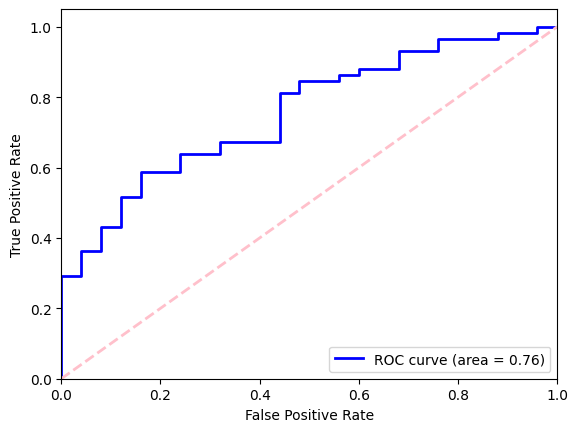

In [20]:
from sklearn.metrics import RocCurveDisplay, roc_curve, auc

def plot_roc(fpr, tpr):
    plt.figure()
    lw = 2 # linewidth
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='blue', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='pink', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.savefig("roc_curve.png")

    print('ROC curve (area = %0.2f)' % roc_auc)
    
fpr, tpr, thresholds = roc_curve(lab, pred)
plot_roc(fpr, tpr)